<a href="https://colab.research.google.com/github/av-dutta/Appliances-Energy-Prediction/blob/main/Appliance_Energy_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data-driven prediction of energy use of appliances**

**The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes (parameters).**

- date time year-month-day hour:minute:second

- Appliances, energy use in Wh (Dependent variable)

- lights, energy use of light fixtures in the house in Wh (Drop this column)

- T1, Temperature in kitchen area, in Celsius

- RH1, Humidity in kitchen area, in %

- T2, Temperature in living room area, in Celsius

- RH2, Humidity in living room area, in %

- T3, Temperature in laundry room area in Celsius

- RH3, Humidity in laundry room area, in % 

- T4, Temperature in office room, in Celsius 

- RH4, Humidity in office room, in %

- T5, Temperature in bathroom, in Celsius

- RH5, Humidity in bathroom, in % 

- T6, Temperature outside the building (north side), in Celsius

- RH6, Humidity outside the building (north side), in %

- T7, Temperature in ironing room , in Celsius

- RH7, Humidity in ironing room, in % 

- T8, Temperature in teenager room 2, in Celsius 

- RH8, Humidity in teenager room 2, in %

- T9, Temperature in parents room, in Celsius

- RH9, Humidity in parents room, in % 

- Tout, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg 

- RHout, Humidity outside (from
Chievres weather station), in %

- Wind speed (from Chievres weather station), in m/s

- Visibility (from Chievres weather station), in km

- Tdewpoint (from Chievres weather station), Â°C

- rv1, Random variable 1, nondimensional

- rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

## Overview of the data:

In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#File path
file_path = '/content/drive/MyDrive/Capstone Project Regression/data_application_energy.csv'
#importing the dataset
data = pd.read_csv(file_path)
#Make a copy of the dataset
df = data.copy()

In [6]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

All the columns are of numerical type and there are no null values in it.

In [ ]:
# Shape of the dataset

print('There are {} rows and {} columns '.format(df.shape[0], df.shape[1]) + 'in the Appliance Energy Prediction Dataset.')

There are 19735 rows and 29 columns in the Appliance Energy Prediction Dataset.


In [ ]:
# Overview of the dataset

df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


## Renaming and Inspection about the features and the target variable:

In [ ]:
# Assigning the original names to the respective columns
df.rename(columns = {'T1' : 'temp_kitchen','RH_1' : 'humid_kitchen',
                     'T2' : 'temp_living','RH_2' : 'humid_living',
                     'T3' : 'temp_laundry', 'RH_3' : 'humid_laundry',
                     'T4' : 'temp_office', 'RH_4' : 'humid_office',
                     'T5' : 'temp_bath', 'RH_5' : 'humid_bath',
                     'T6' : 'temp_outside', 'RH_6' : 'humid_outside',
                     'T7' : 'temp_iron', 'RH_7' : 'humid_iron',
                     'T8' : 'temp_teen', 'RH_8' : 'humid_teen',
                     'T9' : 'temp_parents', 'RH_9' : 'humid_parents',
                     'T_out' : 'temp_station','RH_out' : 'humid_station'},inplace=True)

In [ ]:
# Rechecking dataset with renamed columns

df.head()

,date,Appliances,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,...,temp_parents,humid_parents,temp_station,Press_mm_hg,humid_station,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
# Statistical Summary

round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.69,102.52,10.00,50.00,60.00,100.00,1080.00
lights,19735.0,3.80,7.94,0.00,0.00,0.00,0.00,70.00
temp_kitchen,19735.0,21.69,1.61,16.79,20.76,21.60,22.60,26.26
humid_kitchen,19735.0,40.26,3.98,27.02,37.33,39.66,43.07,63.36
temp_living,19735.0,20.34,2.19,16.10,18.79,20.00,21.50,29.86
humid_living,19735.0,40.42,4.07,20.46,37.90,40.50,43.26,56.03
temp_laundry,19735.0,22.27,2.01,17.20,20.79,22.10,23.29,29.24
humid_laundry,19735.0,39.24,3.25,28.77,36.90,38.53,41.76,50.16
temp_office,19735.0,20.86,2.04,15.10,19.53,20.67,22.10,26.20
humid_office,19735.0,39.03,4.34,27.66,35.53,38.40,42.16,51.09


- Average temperature inside the building is 23 degrees for the recorded time.
- Highest temperature recorded inside is 29.86 degrees which is on the living room while the lowest being 24.5 degrees on the parents room.
- Highest recorded temperature outside is 28.29 degrees and the lowest being -6 degrees
- So this difference in temperature inside and outside are being maintained by using warming appliances.

- It is clearly evident from the given data that average humidity outside is higher in comparison to inside humidity.
- Average humidity in the station is quite higher than the other places.
- Average humidity inside the house is slightly higher in the bathroom.

In [ ]:
# Features other than temperature and humidity

other_cond = df[['Appliances','date','Tdewpoint','Windspeed','Visibility','Press_mm_hg']]

In [ ]:
# Overview

other_cond.head()

,Appliances,date,Tdewpoint,Windspeed,Visibility,Press_mm_hg
0,60,2016-01-11 17:00:00,5.3,7.000000,63.000000,733.5
1,60,2016-01-11 17:10:00,5.2,6.666667,59.166667,733.6
2,50,2016-01-11 17:20:00,5.1,6.333333,55.333333,733.7
3,50,2016-01-11 17:30:00,5.0,6.000000,51.500000,733.8
4,60,2016-01-11 17:40:00,4.9,5.666667,47.666667,733.9


In [ ]:
# Info about the features
other_cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   date         19735 non-null  object 
 2   Tdewpoint    19735 non-null  float64
 3   Windspeed    19735 non-null  float64
 4   Visibility   19735 non-null  float64
 5   Press_mm_hg  19735 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 925.2+ KB


## Date column is converted to date-time dtype:


In [ ]:
# Converting date into pandas datetime format

df['date'] = pd.to_datetime(df['date'])
month = df.groupby(df['date'].dt.strftime('%m'))
hours = df.groupby(df['date'].dt.strftime('%H'))

In [ ]:
# Extracting hour and day of the week using datetime library

df.loc[:,'hour'] = df['date'].dt.hour
df.loc[:,'day_of_week'] = df['date'].dt.dayofweek
df['day_type'] = 'weekend'
df['day_type'][df['date'].dt.day_of_week<5] = 'weekday' # Since dates will be numbered from 0 to 6 starting from Monday

In [ ]:
# Convert hour into dataframe
df['hour'].value_counts().to_frame(name = 'Count').head()

,Count
17,828
18,823
15,822
14,822
13,822


## Inspection about Consumption of Energy in hourly basis:

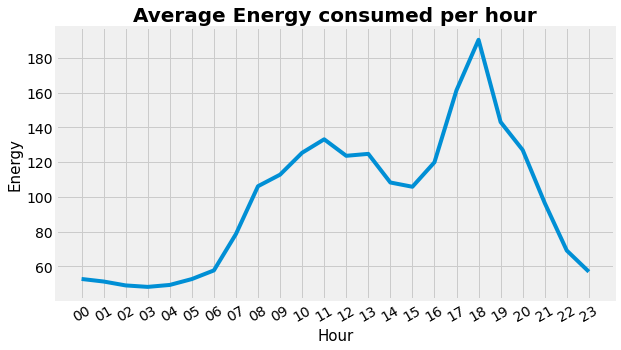

In [ ]:
# LinePlot to visualize the consumption of energy

plt.figure(figsize=[10,5])
plt.style.use('fivethirtyeight')
plt.plot(hours['Appliances'].mean())
plt.title('Average Energy consumed per hour', fontsize = 20, weight = 'bold')
plt.xticks(rotation = '30')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy', fontsize = 15);
plt.show()

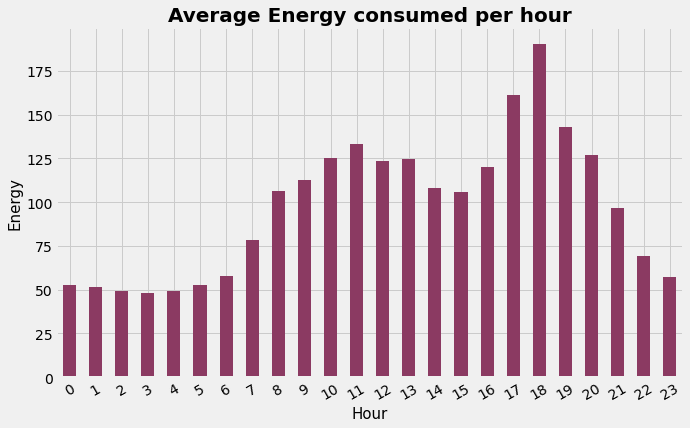

In [ ]:
# BarPlot to visualize the consumption of energy
plt.rcParams['figure.figsize'] = [10, 6]

df.groupby('hour').agg({'Appliances' : 'mean'}).plot.bar(color = '#8B3A62', legend = False)
plt.title('Average Energy consumed per hour', fontsize = 20, weight = 'bold')
plt.xticks(rotation = '30')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy', fontsize = 15);

- It seems that uses of Appliances rises during the day from 7 a.m to 10 p.m.
- Uses peaks at the evening.
- And it goes below 50 at night.


## Feature Engineering of Hour column:

In [ ]:
# Creating bins to divide daytime into different hour slots
hour_bins = [0, 6, 12, 16, 23, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night'] #Since 0 hrs and 24 hrs both represents midnight 
df['Session'] = pd.cut(df.hour, bins = hour_bins, right = False, labels = labels, ordered = False)

In [ ]:
# Now we can drop the date column
df.drop('date', axis = 1,inplace = True)

In [ ]:
# Count

df.day_type.value_counts().to_frame(name = 'Count')

,Count
weekday,14263
weekend,5472


## Univariate analysis:

In [ ]:
#Checking data summary of Appliances

df.Appliances.describe([.70,.80,.9,.99])

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
50%         60.000000
70%         90.000000
80%        110.000000
90%        196.000000
99%        576.600000
max       1080.000000
Name: Appliances, dtype: float64

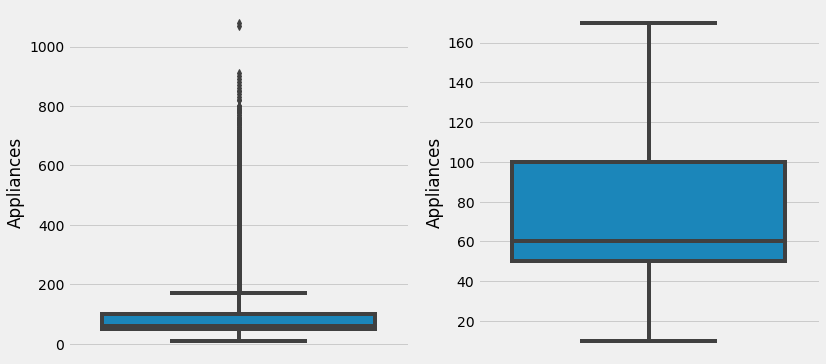

In [ ]:
# Visualizing Appliances using Boxplot to detect outlier values 
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
s1 = sns.boxplot(ax = ax1, y = 'Appliances', data = df, showfliers = True)
s2 = sns.boxplot(ax = ax2, y = 'Appliances', data = df, showfliers = False)
plt.show();

In [ ]:
# Histogram Plot of the dependent variable
import plotly.express as px
px.histogram(df, x='Appliances', nbins = 50, color_discrete_sequence=['indianred'], text_auto = True)

Around 90% of Appliance consumption is less than 200 Wh. Whereas the maximum comsumption is of 1080 Wh which will be the outlier in the given column.

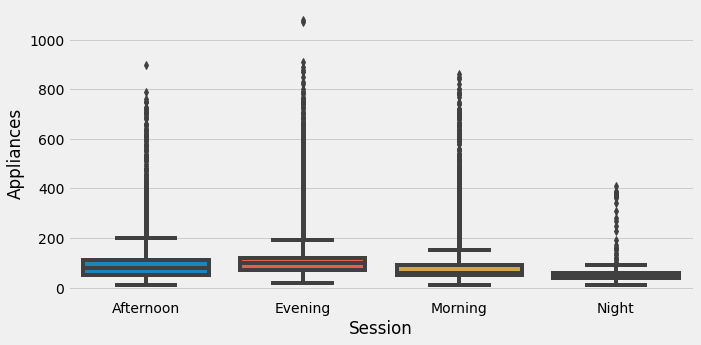

In [ ]:
# Subplots to check the usage throughout the day
fig, ax = plt.subplots(1, 1,figsize = (10,5))
sns.boxplot(ax = ax, x = 'Session', y = 'Appliances', data = df, showfliers = True)
plt.show();

In [ ]:
df.lights.unique() #Unique values corrosponding to light column

array([30, 40, 50, 70, 60, 10, 20,  0])

Light column has only 8 unique values.

In [ ]:
# Let us see the count of value in light column
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
70        1
60        1
Name: lights, dtype: int64

- Since most of the value in lights column is 0 thus we can drop this column.

In [ ]:
# Dropping light column
df.drop('lights', axis=1, inplace =True)

## Correlation Plots:

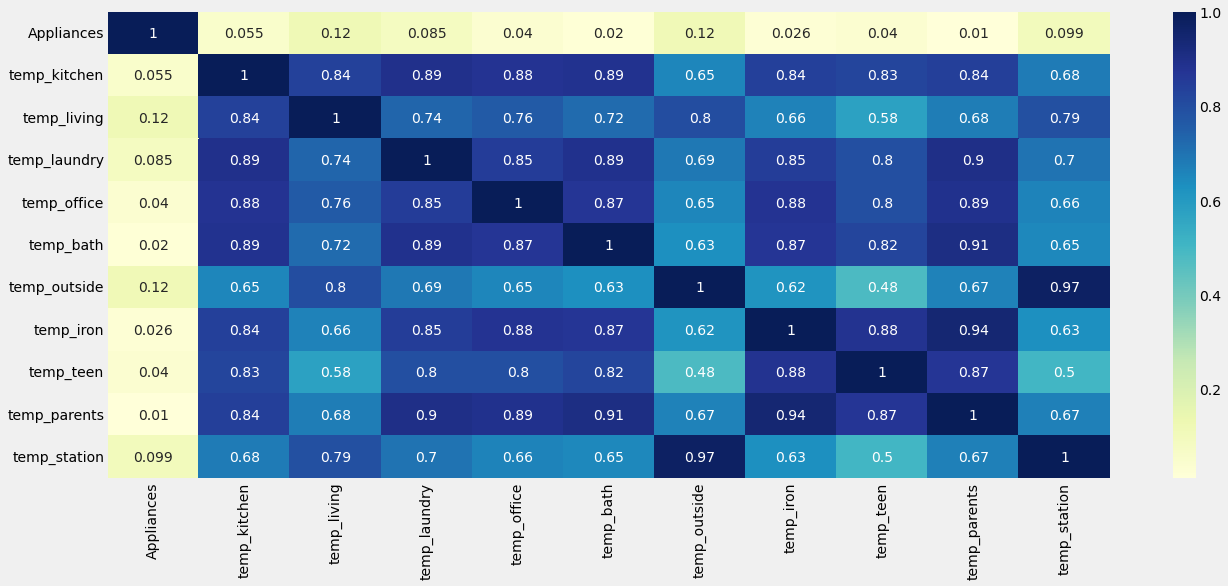

In [ ]:
# Visualization of coorelation of temperature columns with respect to depenent variable
fig, ax = plt.subplots(1,1,figsize = (20, 8))
sns.heatmap(df[['Appliances', 'temp_kitchen', 'temp_living',
        'temp_laundry',  'temp_office',
        'temp_bath',  'temp_outside',
        'temp_iron',  'temp_teen', 
       'temp_parents',  'temp_station']].corr(), cmap='YlGnBu', ax=ax, annot=True);

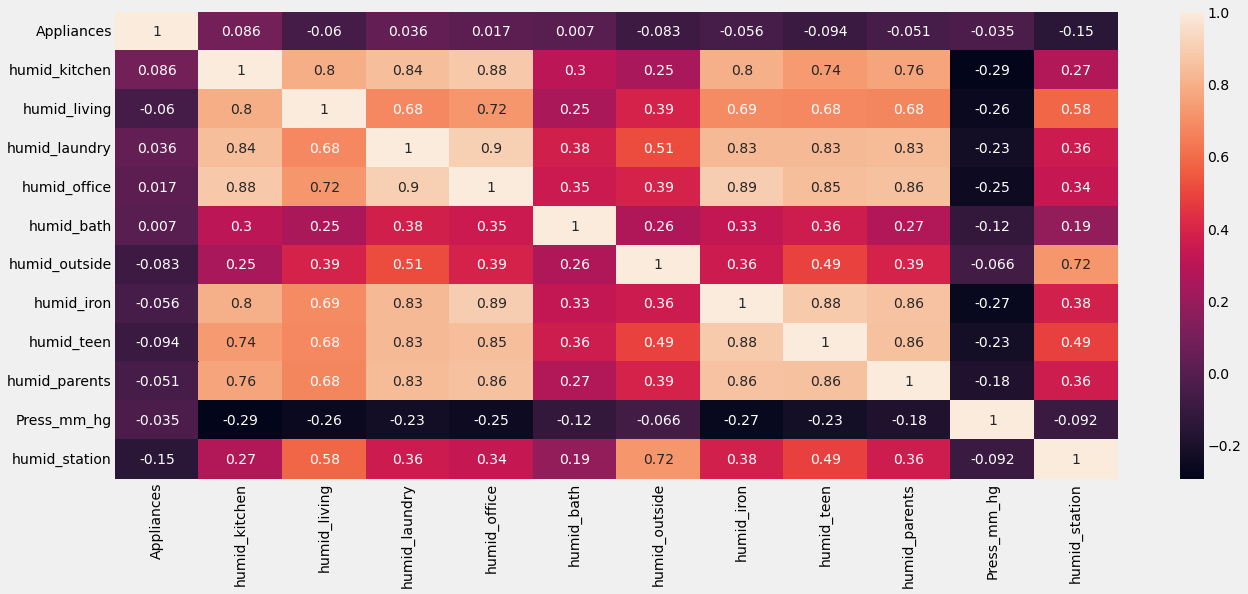

In [ ]:
#Visualization of coorelation of humidity columns with respect to depenent variable

fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(df[['Appliances',  'humid_kitchen', 
       'humid_living',  'humid_laundry', 
       'humid_office',  'humid_bath', 
       'humid_outside',  'humid_iron',  'humid_teen',
        'humid_parents',  'Press_mm_hg',
       'humid_station',]].corr(), ax=ax, annot=True);

In [ ]:
# Correlation of all the variables
df.corr()

,Appliances,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,humid_office,temp_bath,...,temp_station,Press_mm_hg,humid_station,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,day_of_week
Appliances,1.000000,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,0.019760,...,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145,0.216792,0.003060
temp_kitchen,0.055447,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,0.885247,...,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203,0.178858,0.001381
humid_kitchen,0.086031,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,0.205797,...,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699,0.018594,-0.053782
temp_living,0.120073,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,0.720550,...,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087,0.254784,0.000602
humid_living,-0.060465,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,0.110409,...,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275,-0.183322,-0.044249
temp_laundry,0.085060,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,0.888169,...,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194,0.037624,-0.017514
humid_laundry,0.036292,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,-0.050062,...,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477,-0.052392,-0.035182
temp_office,0.040281,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,0.871813,...,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815,0.088407,-0.091006
humid_office,0.016965,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,0.091812,...,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787,-0.019068,-0.005749
temp_bath,0.019760,0.885247,0.205797,0.720550,0.110409,0.888169,-0.050062,0.871813,0.091812,1.000000,...,0.651321,-0.170999,-0.273953,-0.145011,-0.084164,0.588362,-0.005490,-0.005490,0.071340,-0.040827


**OBSERVATIONS :**

* From the correlation graph we clearly observe that the features related to temperature and features related to humidity have positive correlation within themselves whereas have a a very low or negative correlation with each other.**
* Humidity outside have a strong negative correlation with temperature levels .
* Apart from that we observe that a couple features such as humidity at station, temperature outside the building and temperature in the living room have a comparatively high absolute correlation (above 0.15) with Appliances energy consumption.

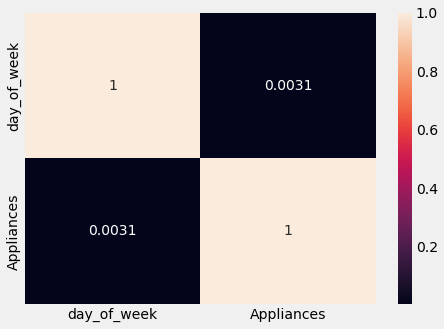

In [ ]:
# Coorelation between day_of_week and appliances
fig,ax = plt.subplots(1,1,figsize = (7,5))
sns.heatmap(df[['day_of_week', 'Appliances']].corr(), ax = ax, annot=True);

There is very little correlation between these two features this might be justified by the use of appliances on weekdays as well as weekends.

**Checking the weather features.**

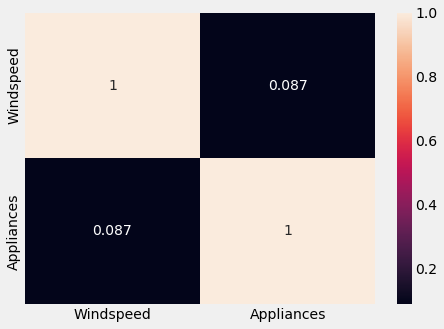

In [ ]:
# Coorelation between windspeed and appliances
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(df[['Windspeed', 'Appliances']].corr(), ax = ax, annot=True);

**Tdewpoint shows a high correlation with most of the tempearture and humidity level features than any other weather parameters. Pressure, windspeed and visibiltiy show little to know correlation. We might need to include these only these feaatures in our final model**

## Histogram of all variables:

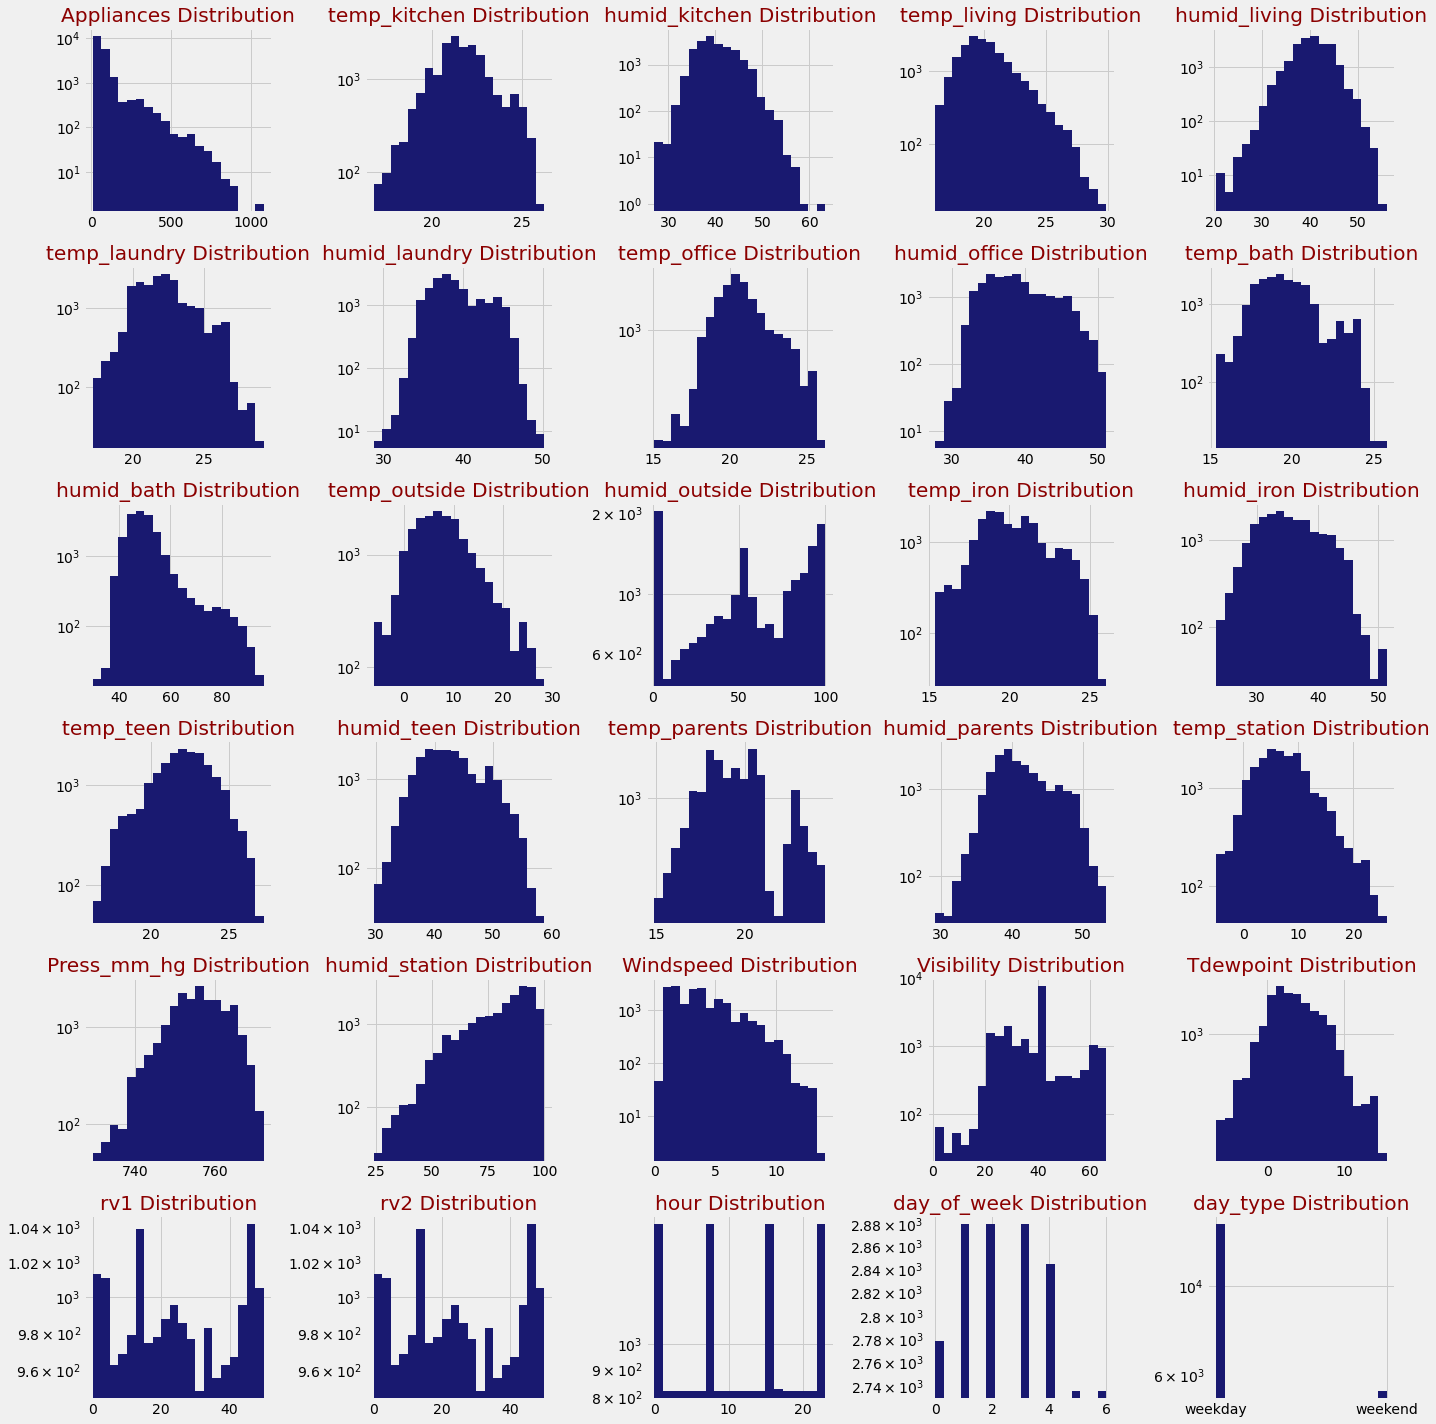

In [ ]:
# Histogram of all the variables
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (20,20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins = 20, ax = ax, facecolor = 'midnightblue')
        ax.set_title(feature+' Distribution', color = 'DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()

draw_histograms(df,df.columns[:-1],6, 5)

* As we have observed earlier as well, there seems to be no correlation between month and the observed energy use i.e. the enegy consumption pretty much remains similar over all months. Similarly there is no direct effect of weekdays on appliance energy consumption.
* Although there is a correlation of 0.22 between hour and appliances

## Checking Multicollinearity and Feature Selection:

In [ ]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

Considering all temperature features VIF is calculated.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['temp_kitchen','temp_living','temp_laundry','temp_office','temp_bath','temp_outside','temp_iron','temp_teen','temp_parents','temp_station']]])

,variables,VIF
0,temp_kitchen,2304.469788
1,temp_living,603.779475
2,temp_laundry,1070.177435
3,temp_office,751.897631
4,temp_bath,965.385831
5,temp_outside,72.595226
6,temp_iron,1100.353627
7,temp_teen,806.118750
8,temp_parents,1897.350478
9,temp_station,67.177429


temp_kitchen, temp_laundry, temp_bath, temp_iron, temp_parents have VIF greater than 1000 so they are not considered for next step.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['temp_living','temp_office','temp_bath','temp_outside','temp_teen','temp_station']]])

,variables,VIF
0,temp_living,251.134421
1,temp_office,580.328850
2,temp_bath,630.268643
3,temp_outside,56.911749
4,temp_teen,429.443084
5,temp_station,61.116932


temp_office, temp_bath are now having VIF greater than 500 so they are not taken into consideration for next step.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['temp_living','temp_outside','temp_teen','temp_station']]])

,variables,VIF
0,temp_living,168.579544
1,temp_outside,56.230412
2,temp_teen,149.104317
3,temp_station,60.091934


'temp_living','temp_outside','temp_teen','temp_station' are the temperature features that will be taken for model building.

VIF is calculated for Humidity featues.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['humid_kitchen','humid_living','humid_laundry','humid_office','humid_bath','humid_outside', 'humid_iron','humid_teen','humid_parents','humid_station']]])

,variables,VIF
0,humid_kitchen,895.145638
1,humid_living,482.347411
2,humid_laundry,797.522900
3,humid_office,852.039518
4,humid_bath,39.022790
5,humid_outside,9.611110
6,humid_iron,326.416844
7,humid_teen,466.277211
8,humid_parents,533.763611
9,humid_station,95.587788


humid_kitchen, humid_laundry, humid_office, humid_parents are the features having VIF greater than 500 so they are eliminated for next step.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['humid_living','humid_bath','humid_outside', 'humid_iron','humid_teen','humid_parents','humid_station']]])

,variables,VIF
0,humid_living,254.335366
1,humid_bath,35.293264
2,humid_outside,8.460885
3,humid_iron,252.206851
4,humid_teen,449.900350
5,humid_parents,382.261195
6,humid_station,83.433909


humid_teen, humid_parents are the featues with VIF greater than 300 so they are removed.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['humid_living','humid_bath','humid_outside', 'humid_iron','humid_station']]])

,variables,VIF
0,humid_living,185.479943
1,humid_bath,33.377959
2,humid_outside,8.314047
3,humid_iron,101.574346
4,humid_station,80.344378


'humid_living','humid_bath','humid_outside', 'humid_iron','humid_station' are the humidity features taken for model building.

In [ ]:
# Inspection about rv1 and rv2
df[['rv1', 'rv2']].describe()

,rv1,rv2
count,19735.000000,19735.000000
mean,24.988033,24.988033
std,14.496634,14.496634
min,0.005322,0.005322
25%,12.497889,12.497889
50%,24.897653,24.897653
75%,37.583769,37.583769
max,49.996530,49.996530


Both rv1 and rv2 have same distribution so they are not taken at a time for VIF calculation.

In [ ]:
# VIF calculation
calc_vif(df[[i for i in df.describe().columns if i in ['Press_mm_hg','Windspeed', 'Visibility', 'Tdewpoint', 'rv1']]])

,variables,VIF
0,Press_mm_hg,17.979729
1,Windspeed,3.752274
2,Visibility,11.594319
3,Tdewpoint,1.829734
4,rv1,3.970648


'Press_mm_hg','Windspeed', 'Visibility', 'Tdewpoint', 'rv1' are considered for model building.

In [ ]:
# Inclusion of featues that will be considered for model building

final_df = df[[ 'Appliances', 'temp_living','temp_outside','temp_teen','temp_station',
                'humid_living','humid_bath','humid_outside', 'humid_iron','humid_station',
                'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1',
                'hour', 'day_of_week', 'day_type', 'Session']]

## Encoding the features:

In [ ]:
# Writing a function for label encoding for education column

def ordinal_encode(day_type):
    if day_type == 'weekend':
        return 1
    else:
        return 2
        
final_df['day_type'] = final_df['day_type'].apply(ordinal_encode)  

In [ ]:
# Writing a function for label encoding for education column

def ordinal(Session):
    if Session == 'Evening':
        return 4
    elif Session == 'Night':
        return 1
    elif Session == 'Morning':
        return 2
    else:
        return 3
final_df['Session'] = final_df['Session'].apply(ordinal)  

In [ ]:
# Session count
final_df.Session.value_counts().to_frame(name = 'Count')

,Count
4,5761
1,5754
2,4932
3,3288


Seperating dependent and independent variables

## Independent and Dependent feature selection:

In [ ]:
# Creating dependent and independent variable

X_ind = final_df.drop('Appliances',axis=1)
Y_dep = final_df['Appliances']

## Splitting in train and test sets:

In [ ]:
# Splitting dataset into train and test dataset using train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ind, Y_dep , test_size = 0.25, random_state = 0) 
print(X_train.shape) #Shape of train dataset
print(X_test.shape) #Shape of test dataset

(14801, 18)
(4934, 18)


## Standarization:

In [ ]:
# Standardizing the values of the features and response in both train and test sets
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

y_train = sc.fit_transform(y_train.values.reshape([-1,1])).flatten()
y_test = sc.transform(y_test.values.reshape([-1,1])).flatten()

## Model Building:

In [ ]:
# Creating list of models to apply
models = [
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor(n_estimators=20,max_depth=200,criterion='mae')],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()]]

In [ ]:
# Fitting the models and calculating the time taken for each fit
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 0
    curr_model_data['Algorithm'] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data['Train_Time'] = end - start
    curr_model_data['Train_R2_Score'] = r2_score(y_train, curr_model.predict(X_train))
    curr_model_data['Test_R2_Score'] = r2_score(y_test, curr_model.predict(X_test))
    curr_model_data['Train_RMSE_Score'] = np.sqrt(mean_squared_error(y_train, curr_model.predict(X_train)))
    curr_model_data['Test_RMSE_Score'] = np.sqrt(mean_squared_error(y_test, curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[15:29:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Storing the results in a dataframe
results_df = pd.DataFrame(model_data)

In [ ]:
# Overview
results_df

,Algorithm,Train_Time,Train_R2_Score,Test_R2_Score,Train_RMSE_Score,Test_RMSE_Score
0,SVR:,11.137127,0.208189,0.160303,8.898377e-01,0.960755
1,RandomForest,263.609790,0.923699,0.508701,2.762270e-01,0.734893
2,ExtraTreeRegressor :,5.869151,1.000000,0.584251,1.331198e-15,0.676032
3,GradientBoostingRegressor:,5.388563,0.324242,0.248996,8.220450e-01,0.908600
4,XGBRegressor:,1.315815,0.319371,0.242087,8.250022e-01,0.912770


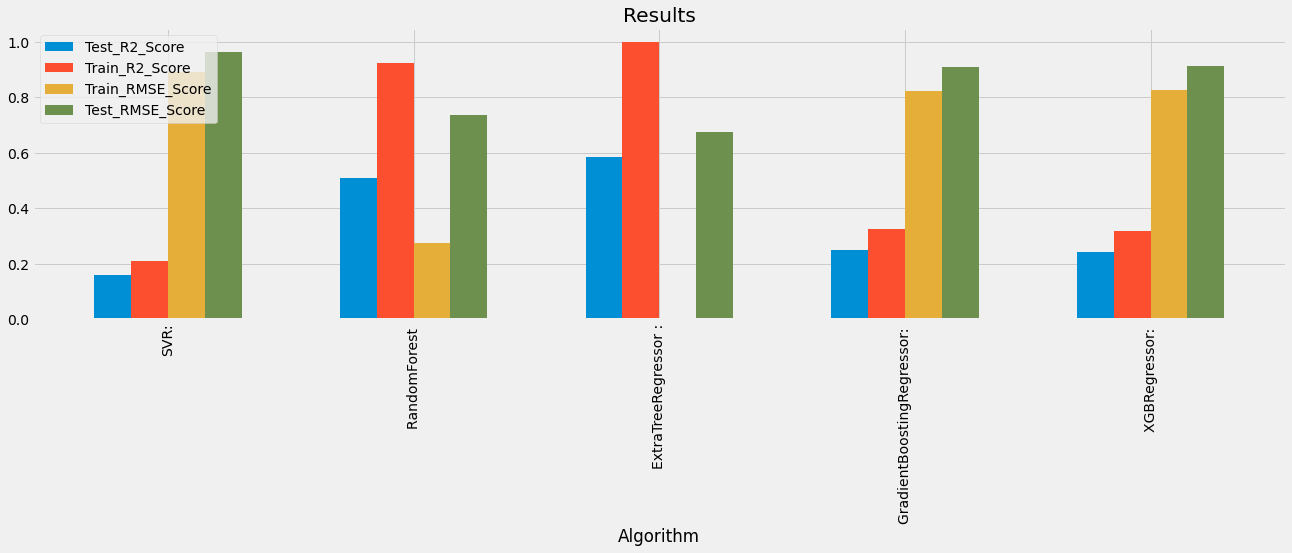

In [ ]:
# Visualization of the results_df

results_df.plot.bar(x = 'Algorithm', y = ['Test_R2_Score' , 'Train_R2_Score' , 
                                      'Train_RMSE_Score','Test_RMSE_Score', ],
                     title = 'Results' , width = .6, figsize = (20, 5))
plt.legend(loc=2);

* From the above results we can see that ExtraTreeRegressor gives out the best possible result.
* Performance of SVR in this case is comparatively poor.

In [ ]:
# A function to calculate R squared, Adjusted R squared, MSE and RMSE for train and test sets

def evaluate(model, X_train, X_test, y_train, y_test):

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, train_pred)
    print('R2 score for the training data is:' , r2_train)
    print('Adjusted R2 : ',1-(1-r2_score((y_train), (train_pred)))*((X_test.shape[0]-1)/
                                                                     (X_test.shape[0]-X_test.shape[1]-1)))

    r2_test = r2_score(y_test, test_pred)
    print('R2 score for the test data is:' , r2_test)
    print('Adjusted R2 : ',1-(1-r2_score((y_test), (test_pred)))*((X_test.shape[0]-1)/
                                                                     (X_test.shape[0]-X_test.shape[1]-1)))

    train_MSE  = mean_squared_error(y_train, train_pred)
    print('MSE for the training data is:' , train_MSE)

    train_RMSE = np.sqrt(train_MSE)
    print('RMSE for the training data is:' , train_RMSE)

    test_pred = model.predict(X_test)

    test_MSE  = mean_squared_error(y_test, test_pred)
    print('MSE for the test data is:' , test_MSE)

    test_RMSE = np.sqrt(test_MSE)
    print('RMSE for the test data is:' ,test_RMSE)

### Lasso:

In [ ]:
# Lasso
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha = 0.0001 , max_iter = 3000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, max_iter=3000)

In [ ]:
# Checking for different metrics for Lasso Regression
evaluate(lasso, X_train, X_test, y_train, y_test)

R2 score for the training data is: 0.10484796367480764
Adjusted R2 :  0.10156968561705515
R2 score for the test data is: 0.09057161128563906
Adjusted R2 :  0.08724104953653256
MSE for the training data is: 0.8951520363251924
RMSE for the training data is: 0.9461247467037274
MSE for the test data is: 0.9997039933538271
RMSE for the test data is: 0.9998519857228004


In [ ]:
# Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best parameters of Lasso Regression
print('The best fit alpha value is found out to be :' ,lasso_regressor.best_params_)
print('\nUsing ',lasso_regressor.best_params_, ' the negative mean squared error is: ', lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.0001}

Using  {'alpha': 0.0001}  the negative mean squared error is:  -0.8973500600324101


In [ ]:
# Predicting for Lasso Regression 
y_pred_lasso = lasso_regressor.predict(X_test)

In [ ]:
# Checking for different metrics for Hyper-parameter tuned Lasso Regression
evaluate(lasso_regressor, X_train, X_test, y_train, y_test)

R2 score for the training data is: 0.10484796367480764
Adjusted R2 :  0.10156968561705515
R2 score for the test data is: 0.09057161128563906
Adjusted R2 :  0.08724104953653256
MSE for the training data is: 0.8951520363251924
RMSE for the training data is: 0.9461247467037274
MSE for the test data is: 0.9997039933538271
RMSE for the test data is: 0.9998519857228004


### Ridge:

In [ ]:
# Ridge

from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best parameters of Ridge Regression
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -0.8968611504898778


In [ ]:
# Predicting for Ridge Regression 
y_pred_ridge = ridge_regressor.predict(X_test)

In [ ]:
# Checking for different metrics for Hyper-parameter tuned Ridge Regression
evaluate(ridge_regressor, X_train, X_test, y_train, y_test)

R2 score for the training data is: 0.10485608555007675
Adjusted R2 :  0.10157783723673008
R2 score for the test data is: 0.0905932899761146
Adjusted R2 :  0.08726280761997418
MSE for the training data is: 0.8951439144499233
RMSE for the training data is: 0.9461204545140768
MSE for the test data is: 0.9996801626996404
RMSE for the test data is: 0.9998400685607876


### ExtraTreesRegressor:

In [ ]:
# Implementing RandomizedSearchCV to ExtraTreesRegressor

from sklearn.model_selection import RandomizedSearchCV
param_random = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state = 40)
random_search = RandomizedSearchCV(estimator = reg, param_distributions = param_random, cv = 5, 
                                   n_jobs = -1 , scoring='r2' , n_iter = 5, verbose = 2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=40),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'max_depth': [80, 150, 200, 250],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'n_estimators': [100, 150, 200, 250]}],
                   scoring='r2', verbose=2)

In [ ]:
# Best parameters of hyperparameter tuned ExtraTreesRegressor
random_search.best_params_

{'max_depth': 250, 'max_features': 'sqrt', 'n_estimators': 150}

In [ ]:
# Best estimators of hyperparameter tuned ExtraTreesRegressor
random_search.best_estimator_

ExtraTreesRegressor(max_depth=250, max_features='sqrt', n_estimators=150,
                    random_state=40)

In [ ]:
# Checking for different metrics for Hyper-parameter tuned ExtraTreesRegressor
evaluate(random_search.best_estimator_, X_train, X_test, y_train, y_test)

R2 score for the training data is: 1.0
Adjusted R2 :  1.0
R2 score for the test data is: 0.6103302505378914
Adjusted R2 :  0.608903179227552
MSE for the training data is: 4.386812944577575e-30
RMSE for the training data is: 2.0944719966085903e-15
MSE for the test data is: 0.4283508294448119
RMSE for the test data is: 0.654485163655229


### RandomForestRegressor:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 57, 105, 152, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, 
                               verbose = 2, random_state = 42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 32, 55, 77, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 57, 105, 152,
                                                         200]},
                   random_state=42, verbose=2)

In [ ]:
# Best parameters of hyperparameter tuned RandomForestRegressor
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
# Best estimators of hyperparameter tuned RandomForestRegressor
best_random = rf_random.best_estimator_

In [ ]:
# Checking for different metrics for Hyper-parameter tuned RandomForestRegressor
evaluate(best_random, X_train, X_test, y_train, y_test)

R2 score for the training data is: 0.9776492207752948
Adjusted R2 :  0.9775673664464963
R2 score for the test data is: 0.5951346573780215
Adjusted R2 :  0.5936519358791007
MSE for the training data is: 0.022350779224705162
RMSE for the training data is: 0.1495017699718139
MSE for the test data is: 0.4450548331374802
RMSE for the test data is: 0.6671243011144776


## Stacking:

In [ ]:
# Baseline Algorithms

## DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 0, min_samples_split = 5, min_impurity_decrease = 0.001)

## SupportVectorRegressor
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')

## KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors = 5, p = 2)

##ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators = 200, random_state = 0)

# Meta Algorithm
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0) 

In [ ]:
# StackingRegressor

estimators = [('DecisonTreeRegressor', dtr),
              ('SupportVectorRegressor', svr),
              ('KNeighborsRegressor', knr),
              ('ExtraTreesRegressor', etr)]
              
from sklearn.ensemble import StackingRegressor
SR = StackingRegressor(estimators = estimators, final_estimator = rfr)

In [ ]:
 # Train Score

print(SR.fit(X_train, y_train).score(X_train, y_train))

0.9261910905713578


In [ ]:
# Test Score

print(SR.fit(X_train, y_train).score(X_test, y_test))

0.5416133534277369
